In [12]:
# converting image to ela image
from glob import glob 
from tqdm import tqdm
from PIL import Image, ImageChops, ImageEnhance
import os 

# EDA

In [13]:
total_files = glob("../input/casia-dataset/CASIA2/**/*")
print('total files', len(total_files))

# types of files
types = set()
for file in total_files:
    types.add(file.split(".")[-1])
print('types of files in the folder', types)

# jpg files
jpg_files = glob("../input/casia-dataset/CASIA2/*/*.jpg")
print('jpg files: ', len(jpg_files))

#tif files
tif_files = glob("../input/casia-dataset/CASIA2/**/*.tif")
print('tif files: ', len(tif_files))

#TOTAL jpg file whose name starts with Tp
tp_jpg_files = glob("../input/casia-dataset/CASIA2/**/Tp*")
print('tp_jpg_files: ', len(tp_jpg_files))
print('first 5 tp_jpg_files: ', tp_jpg_files[:5])

total files 12616
types of files in the folder {'db', 'tif', 'jpg', 'JPG', 'bmp'}
jpg files:  9418
tif files:  3059
tp_jpg_files:  5123
first 5 tp_jpg_files:  ['../input/casia-dataset/CASIA2/Tp/Tp_D_NRN_M_N_nat00025_nat00028_11037.jpg', '../input/casia-dataset/CASIA2/Tp/Tp_S_NND_S_N_arc00012_arc00012_01111.tif', '../input/casia-dataset/CASIA2/Tp/Tp_S_NRN_S_N_art20038_art20038_01844.tif', '../input/casia-dataset/CASIA2/Tp/Tp_S_NRN_S_N_art00092_art00092_11809.jpg', '../input/casia-dataset/CASIA2/Tp/Tp_S_NNN_S_N_txt00060_txt00060_01282.tif']


# Data Preprocessing

In [14]:
def convert_to_ela_image(image_path, quality=90):
    # Save the image at the given quality
    temp_file = 'temp.jpg'
    im = Image.open(image_path).convert('RGB')
    im.save(temp_file, 'JPEG', quality=quality)

    # Open the saved image and the original image
    saved = Image.open(temp_file)
    orignal = Image.open(image_path)

    # Find the absolute difference between the images
    diff = ImageChops.difference(orignal, saved)

    # Normalize the difference by multiplying with a scale factor and convert to grayscale
    extrema = diff.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    scale = 255.0 / max_diff
    diff = ImageEnhance.Brightness(diff).enhance(scale)

    # Remove the temporary file
    os.remove(temp_file)

    return diff

In [15]:
images = jpg_files
print('jpeg files', len(images))
images.extend(tif_files)
print('total images', len(images))

jpeg files 9418
total images 12477


In [16]:
# find the number of files whose name starts with Tp in a list 
def find_tp_files(files):
    tp_files, au_files = 0, 0
    for file in files:
        if file.split("/")[-1].split("_")[0] == 'Tp':
            tp_files += 1
        if file.split("/")[-1].split("_")[0] == "Au":
            au_files += 1
    return tp_files, au_files
find_tp_files(images)

(5123, 7354)

# ELA images

In [92]:
# # converting images to ela images
# for image in tqdm(images):
#     # converting image to ela image
#     ela_image = convert_to_ela_image(image)
#     # creating a new directory for ela images
#     if not os.path.exists('/CASIA2_ELA'):
#         os.mkdir('/CASIA2_ELA')
# #     print('/CASIA2_ELAtp/' + image.split('/')[-1])
#     ela_image.save('/CASIA2_ELA/' + image.split('/')[-1])

In [18]:
# types of files
total_files = glob('/CASIA2_ELA/*')
print('total els files', len(total_files))
types = set()
for file in total_files:
    types.add(file.split(".")[-1])
print('types of files in the folder', types)

total els files 11957
types of files in the folder {'tif', 'jpg'}


In [19]:
find_tp_files(total_files)

(4603, 7354)

# UTILS

In [20]:
# counting the number of each class in the dataset
def count_classes(dataloader):
    tempered, original = 0, 0
    for images, labels in tqdm(dataloader):
        for label in labels:
            if label == 1:
                tempered += 1
            else:
                original += 1
    print(f"Tempered: {tempered}, Original: {original}")

# Creating Custom PyTorch DataLoader

In [22]:
# importing the datasets 
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from glob import glob
from torchvision import transforms
from PIL import Image
import torch 
import random

# creating a class for the dataset
class CASIA2_ELA(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = image.split("/")[-1].split("_")[0]
        label = 1 if label == 'Tp' else 0
        image = Image.open(image)
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float32)

# testing the dataset
def test():
    all_images = glob("/CASIA2_ELA/*")
    random.shuffle(all_images)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    dataset = CASIA2_ELA(all_images, transform=transform)
    print(dataset[1][0].shape)
    print(dataset[1][1])

if __name__ == "__main__":
    test()

torch.Size([3, 224, 224])
tensor(0.)


In [23]:
# from dataset import CASIA2_ELA
from torchvision import models
from torch import nn, optim
import random 
import torch 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_images = glob("/CASIA2_ELA/*.jpg")
# shuffle the images
random.shuffle(all_images)

all_images = glob("/CASIA2_ELA/*")
random.shuffle(all_images)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
dataset = CASIA2_ELA(all_images, transform=transform)

In [24]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, Subset

def split_dataset(dataset, train_size=0.8):
    # get the indices of the images
    indices = list(range(len(dataset)))
    # get the labels of the images
    labels = [dataset[i][1] for i in indices]
    # split the indices into train and validation indices
    train_indices, val_indices, train_labels, val_labels = train_test_split(indices, labels, train_size=train_size, stratify=labels)
    # create the train and validation subsets
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    return train_dataset, val_dataset

In [25]:
%time train_ds, valid_ds = split_dataset(dataset)

CPU times: user 47.5 s, sys: 820 ms, total: 48.4 s
Wall time: 48.6 s


In [26]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dataset = DataLoader(valid_ds, batch_size=32, shuffle=False)

In [27]:
count_classes(train_loader)

100%|██████████| 299/299 [00:41<00:00,  7.19it/s]

Tempered: 3682, Original: 5883


In [28]:
count_classes(val_dataset)

100%|██████████| 75/75 [00:09<00:00,  7.51it/s]

Tempered: 921, Original: 1471


# Visualizing

In [319]:
import matplotlib.pyplot as plt 
def visualize(dataloader):
    for images, labels in dataloader:
        print(images.shape)
        print(labels.shape)
        plt.figure(figsize=(16, 8))
        for i in range(32):
            plt.subplot(4, 8, i+1)
            plt.imshow(images[i].permute(1, 2, 0))
            plt.title(f"Label: {labels[i]}")
            plt.axis("off")
        plt.show()
        break

torch.Size([32, 3, 224, 224])
torch.Size([32])


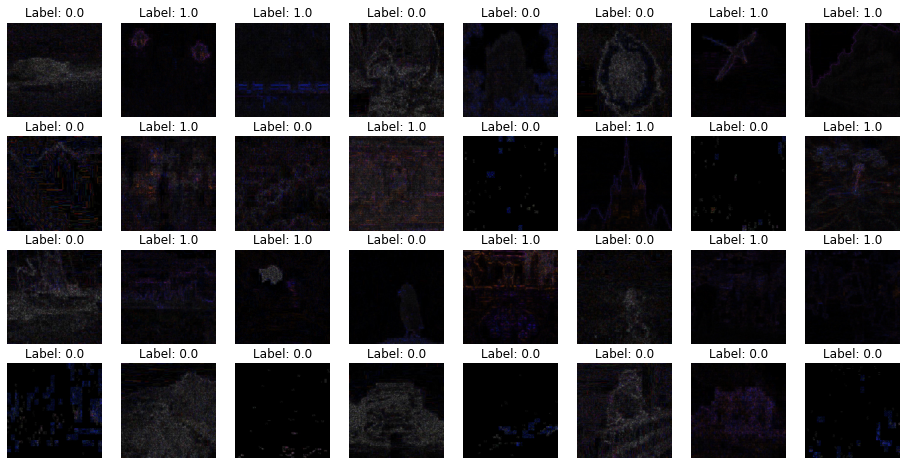

In [320]:
visualize(train_loader)

# Model

In [65]:
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(774400, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        out = nn.Sigmoid()
        return out(x)
    
model = CNN()
model.to(device)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=774400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

# Training Function

In [85]:
# define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

**Testing training loop**

In [86]:
train_sub = Subset(train_ds, range(2000))
train_sub_dl = DataLoader(train_sub, batch_size=32, shuffle=True)

In [87]:
from sklearn.metrics import f1_score
losses = []
accuracy = []
for epch in range(5):
    for xb, yb in tqdm(train_sub_dl):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        yb_ = model(xb)
        loss = criterion(yb_.squeeze(1), yb)
        losses.append(loss.item())
        batch_acc = f1_score(yb.cpu().detach().numpy(), yb_.cpu().detach().numpy().round(), )
        accuracy.append(batch_acc)
        loss.backward()
        optimizer.step()

100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


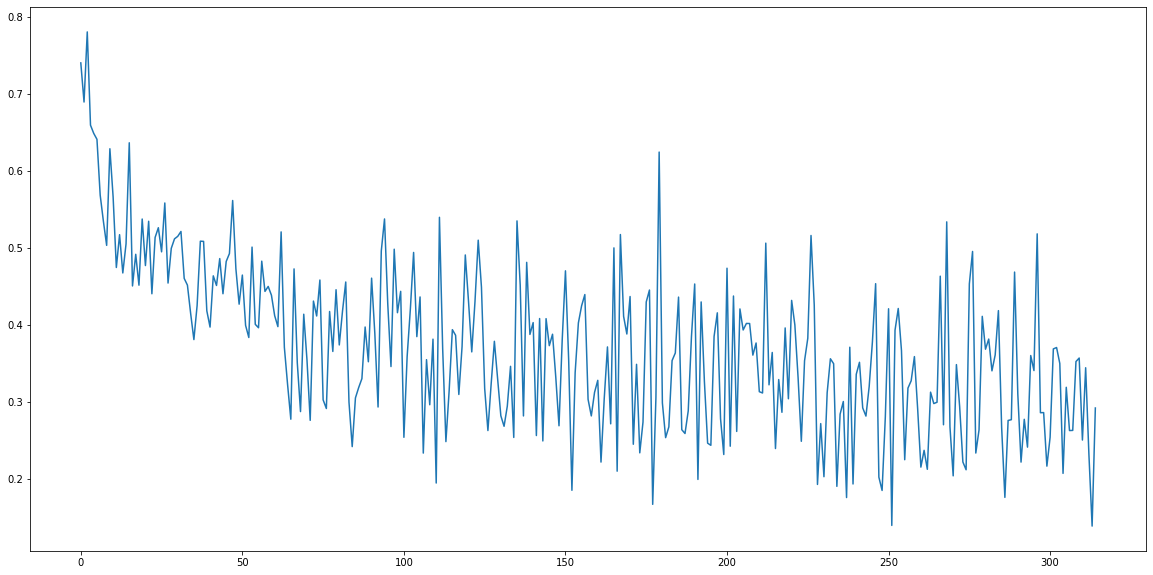

In [88]:
plt.figure(figsize = (20, 10))
plt.plot(losses)

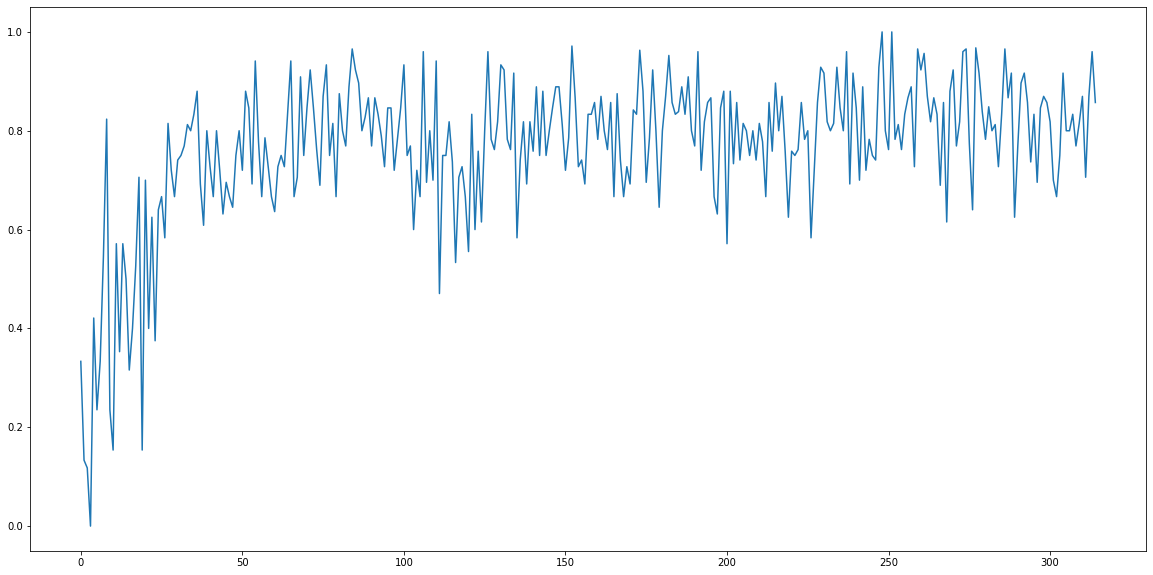

In [89]:
plt.figure(figsize = (20, 10))
plt.plot(accuracy)

# Training the model

In [90]:
from sklearn.metrics import accuracy_score, f1_score

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    for epoch in range(num_epochs):
        model.train()
        for xb, yb in tqdm(train_loader):
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            yb_ = model(xb)
            loss = criterion(yb_.squeeze(1), yb)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            batch_acc = accuracy_score(yb.cpu().detach().numpy(), yb_.cpu().detach().numpy().round())
            train_acc.append(batch_acc)
        model.eval()
        with torch.no_grad():
            for xb, yb in tqdm(val_loader):
                xb, yb = xb.to(device), yb.to(device)
                yb_ = model(xb)
                loss = criterion(yb_.squeeze(1), yb)
                val_loss.append(loss.item())
                batch_acc = accuracy_score(yb.cpu().detach().numpy(), yb_.cpu().detach().numpy().round())
                val_acc.append(batch_acc)
        print(f'Epoch: {epoch+1}, Train Loss: {torch.tensor(train_loss).mean():.4f}, Train Accuracy: {torch.tensor(train_acc).mean():.4f}, Val Loss: {torch.tensor(val_loss).mean():.4f}, Val Accuracy: {torch.tensor(val_acc).mean():.4f}')

In [91]:
train_model(model, train_loader, val_dataset, criterion, optimizer, num_epochs=5, device=device)

100%|██████████| 75/75 [00:12<00:00,  5.90it/s]


Epoch: 1, Train Loss: 0.3164, Train Accuracy: 0.8613, Val Loss: 0.3180, Val Accuracy: 0.8776


100%|██████████| 75/75 [00:12<00:00,  5.89it/s]


Epoch: 2, Train Loss: 0.3117, Train Accuracy: 0.8642, Val Loss: 0.3039, Val Accuracy: 0.8840


100%|██████████| 75/75 [00:12<00:00,  5.95it/s]


Epoch: 3, Train Loss: 0.3062, Train Accuracy: 0.8663, Val Loss: 0.2971, Val Accuracy: 0.8862


100%|██████████| 75/75 [00:12<00:00,  5.93it/s]


Epoch: 4, Train Loss: 0.3016, Train Accuracy: 0.8677, Val Loss: 0.2931, Val Accuracy: 0.8870


100%|██████████| 75/75 [00:12<00:00,  5.90it/s]

Epoch: 5, Train Loss: 0.2998, Train Accuracy: 0.8688, Val Loss: 0.2892, Val Accuracy: 0.8871


In [93]:
train_model(model, train_loader, val_dataset, criterion, optimizer, num_epochs=5, device=device)

100%|██████████| 75/75 [00:12<00:00,  5.93it/s]


Epoch: 1, Train Loss: 0.2768, Train Accuracy: 0.8787, Val Loss: 0.2800, Val Accuracy: 0.8912


100%|██████████| 75/75 [00:12<00:00,  5.94it/s]


Epoch: 2, Train Loss: 0.2776, Train Accuracy: 0.8804, Val Loss: 0.2810, Val Accuracy: 0.8917


100%|██████████| 75/75 [00:12<00:00,  5.95it/s]


Epoch: 3, Train Loss: 0.2791, Train Accuracy: 0.8792, Val Loss: 0.2804, Val Accuracy: 0.8919


100%|██████████| 75/75 [00:12<00:00,  5.92it/s]


Epoch: 4, Train Loss: 0.2788, Train Accuracy: 0.8793, Val Loss: 0.2786, Val Accuracy: 0.8909


100%|██████████| 75/75 [00:12<00:00,  5.79it/s]

Epoch: 5, Train Loss: 0.2782, Train Accuracy: 0.8792, Val Loss: 0.2787, Val Accuracy: 0.8909
